## 311 Analysis of the data aggregation: Count by 365 days 
#### author: Duke Yang (shy256)

In [1]:
# stat & math
import pandas as pd
import geopandas as gpd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
import numpy as np
from numpy import array as arr
from numpy.linalg import svd
from sklearn.preprocessing import scale
from sympy import init_printing
import sympy

# misc
import gc
from pprint import pprint
from datetime import datetime, timedelta

# viz
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
init_printing(use_latex=True, use_unicode=True)

#### Data(__DATA_FILE_PATH__) can be found [here](https://drive.google.com/open?id=1RgfW8ELTtr1O63UBCwJ4ui5w3lg2T-81)

In [2]:
__DATA_FILE_PATH__ = '../data/DEP_NTANM_NZONLY_311_Service_Requests_from_2010_to_Present.csv'
__COMPLAINT_TYPES__ = [
'Noise - Vehicle', 'Noise - Street/Sidewalk', 'Noise - Commercial',
       'Noise - Residential', 'Noise', 'Noise - Park',
       'Noise - Helicopter', 'Noise - House of Worship',
       'Collection Truck Noise'
#     , 'Noise Survey'
]

In [3]:
def _convert_dt(dt):
    try:
        return pd.to_datetime(dt, format='%Y-%m-%d %H:%M:%S')
    except:
        return np.nan


__RAW_DF__ = pd.read_csv(
    __DATA_FILE_PATH__
    , converters={k: _convert_dt for k in ['Created Date', 'Closed Date', 'Due Date' , 'Resolution Action Updated Date']}
)

In [4]:
__RAW_DF__.shape

In [5]:
__RAW_DF__.columns

Index(['Created Date', 'Closed Date', 'Agency', 'Agency Name', 'Complaint Type', 'Descriptor', 'Incident Zip', 'Incident Address', 'Street Name', 'Cross Street 1', 'Cross Street 2', 'Address Type', 'City', 'Status', 'Due Date', 'Resolution Description', 'Resolution Action Updated Date', 'Community Board', 'BBL', 'Borough', 'X Coordinate (State Plane)', 'Y Coordinate (State Plane)', 'Open Data Channel Type', 'Park Facility Name', 'Park Borough', 'Latitude', 'Longitude', 'Location', 'geom', 'boro_code', 'boro_name', 'county_fip', 'ntacode', 'ntaname', 'shape_area', 'shape_leng'], dtype='object')

| Column Name                    | Description                                                                                                                                                                                  |
|--------------------------------|----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| Unique Key                     | Unique identifier of a Service Request (SR) in the open data set                                                                                                                             |
| Created Date                   | Date SR  was created                                                                                                                                                                         |
| Closed Date                    | Date SR was closed by responding agency                                                                                                                                                      |
| Agency                         | Acronym of responding City Government Agency                                                                                                                                                 |
| Agency Name                    | Full Agency name of responding City Government Agency                                                                                                                                        |
| Complaint Type                 | This is the fist level of a hierarchy identifying the topic of the incident or condition. Complaint Type may have a corresponding Descriptor (below) or may stand alone.                     |
| Descriptor                     | This is  associated to the Complaint Type and provides further detail on the incident or condition. Descriptor values are dependent on the Complaint Type and are not always required in SR. |
| Status                         | Status of SR submitted                                                                                                                                                                       |
| Due Date                       | Date when responding agency is expected to update the SR.  This is based on the Complaint Type and internal Service Level Agreements (SLAs).                                                 |
| Resolution Action Updated Date | Date when responding agency last updated the SR.                                                                                                                                             |
| Resolution Description         | Describes the last action taken on the SR by the responding agency.  May describe next or future steps.                                                                                      |
| Location Type                  | Describes the type of location used in the address information                                                                                                                               |
| Incident Zip                   | Incident location zip code provided by geo validation.                                                                                                                                       |
| Incident Address               | House number of incident address provided by submitter.                                                                                                                                      |
| Street Name                    | Street name of incident address provided by the submitter                                                                                                                                    |
| Cross Street 1                 | First Cross street based on the geo validated incident location                                                                                                                              |
| Cross Street 2                 | Second Cross Street based on the geo validated incident location                                                                                                                             |
| Intersection Street 1          | First intersecting street based on geo validated incident location                                                                                                                           |
| Intersection Street 2          | Second intersecting street based on geo validated incident location                                                                                                                          |
| Address Type                   | Type of incident location information available.                                                                                                                                             |
| City                           | City of the incident location provided by geovalidation.                                                                                                                                     |
| Landmark                       | If the incident location is identified as a Landmark the name of the landmark will display here                                                                                              |
| Facility Type                  | If available this field describes the type of city facility associated to the SR                                                                                                             |
| Community Board                | Provided by geovalidation.                                                                                                                                                                   |
| BBL                            | Borough Block and Lot provided by geovalidation.  Parcel number to identify the location of location of buildings and properties in NYC.                                                     |
| Borough                        | Provided by the submitter and confirmed by geovalidation.                                                                                                                                    |
| X Coordinate (State Plane      | Geo validated X coordinate of the incident location.                                                                                                                                         |
| Y Coordinate (State Plane      | Geo validated  Y coordinate of the incident location.                                                                                                                                        |
| Open_Data_Channel_Type         | Indicates how the SR was submitted to 311.  i.e. By Phone Online Mobile Other or Unknown.                                                                                                    |
| Latitude                       | Geo based Lat of the incident location                                                                                                                                                       |
| Longitude                      | Geo based Long of the incident location                                                                                                                                                      |
| Location                       | Combination of the geo based lat & long of the incident location                                                                                                                             |
| Park Facility Name             | If the incident location is a Parks Dept facility the Name of the facility will appear here                                                                                                  |
| Park Borough                   | The borough of incident if it is a Parks Dept facility                                                                                                                                       |
| Vehicle Type                   | If the incident is a taxi this field describes the type of TLC vehicle.                                                                                                                      |
| Taxi Company Borough           | If the incident is identified as a taxi this field will display the borough of the taxi company.                                                                                             |
| Taxi Pick Up Location          | If the incident is identified as a taxi this field displays the taxi pick up location                                                                                                        |
| Bridge Highway Name            | If the incident is identified as a Bridge/Highway the name will be displayed here.                                                                                                           |
| Bridge Highway Direction       | If the incident is identified as a Bridge/Highway the direction where the issue took place would be displayed here.                                                                          |
| Road Ramp                      | If the incident location was Bridge/Highway this column differentiates if the issue was on the Road or the Ramp.                                                                             |
| Bridge Highway Segment         | Additional information on the section of the Bridge/Highway were the incident took place.                                                                                                    |

In [6]:
__RAW_DF__.head()

,Created Date,Closed Date,Agency,Agency Name,Complaint Type,Descriptor,Incident Zip,Incident Address,Street Name,Cross Street 1,Cross Street 2,Address Type,City,Status,Due Date,Resolution Description,Resolution Action Updated Date,Community Board,BBL,Borough,X Coordinate (State Plane),Y Coordinate (State Plane),Open Data Channel Type,Park Facility Name,Park Borough,Latitude,Longitude,Location,geom,boro_code,boro_name,county_fip,ntacode,ntaname,shape_area,shape_leng
0,2017-09-12 18:21:00,2017-09-15 22:30:00,DEP,Department of Environmental Protection,Noise,Noise: air condition/ventilation equipment (NV1),11216.0,1232 BEDFORD AVENUE,BEDFORD AVENUE,HANCOCK ST,HALSEY ST,ADDRESS,BROOKLYN,Closed,NaT,The Department of Environmental Protection det...,2017-09-15 22:30:00,03 BROOKLYN,3.020000e+09,BROOKLYN,997116.0,187685.0,ONLINE,Unspecified,BROOKLYN,40.681819,-73.953612,"(40.68181938473442, -73.95361203646364)",POINT (-73.95361203646364 40.68181938473442),3.0,Brooklyn,47,BK69,Clinton Hill,2.052820e+07,23971.465822
1,2017-09-13 14:58:00,2017-09-13 15:36:00,DEP,Department of Environmental Protection,Noise,"Noise, Barking Dog (NR5)",11205.0,219 WASHINGTON AVENUE,WASHINGTON AVENUE,MYRTLE AVE,WILLOUGHBY AVE,ADDRESS,BROOKLYN,Closed,NaT,The Department of Environmental Protection det...,2017-09-13 15:36:00,02 BROOKLYN,3.019040e+09,BROOKLYN,993497.0,191488.0,ONLINE,Unspecified,BROOKLYN,40.692262,-73.966655,"(40.6922622678706, -73.96665500760106)",POINT (-73.96665500760106 40.6922622678706),3.0,Brooklyn,47,BK69,Clinton Hill,2.052820e+07,23971.465822
2,2017-09-13 03:13:00,2017-09-13 21:26:00,DEP,Department of Environmental Protection,Noise,Noise: Alarms (NR3),11238.0,101 QUINCY STREET,QUINCY STREET,CLASSON AVE,FRANKLIN AVE,ADDRESS,BROOKLYN,Closed,NaT,The Department of Environmental Protection res...,2017-09-13 21:26:00,03 BROOKLYN,3.019700e+09,BROOKLYN,996060.0,189277.0,PHONE,Unspecified,BROOKLYN,40.686191,-73.957417,"(40.68619053293611, -73.95741662072693)",POINT (-73.95741662072693 40.68619053293611),3.0,Brooklyn,47,BK69,Clinton Hill,2.052820e+07,23971.465822
3,2017-09-14 18:55:00,2017-09-19 10:34:00,DEP,Department of Environmental Protection,Noise,"Noise, Barking Dog (NR5)",11238.0,510 WASHINGTON AVENUE,WASHINGTON AVENUE,GATES AVE,FULTON ST,ADDRESS,BROOKLYN,Closed,NaT,The Department of Environmental Protection det...,2017-09-19 10:34:00,02 BROOKLYN,3.019780e+09,BROOKLYN,993977.0,188377.0,ONLINE,Unspecified,BROOKLYN,40.683723,-73.964929,"(40.68372277301225, -73.96492860317981)",POINT (-73.96492860317981 40.68372277301225),3.0,Brooklyn,47,BK69,Clinton Hill,2.052820e+07,23971.465822
4,2017-09-15 06:06:00,2017-09-29 07:00:00,DEP,Department of Environmental Protection,Noise,Noise: Construction Before/After Hours (NM1),11238.0,1068 FULTON STREET,FULTON STREET,CLASSON AVE,CLAVER PL,ADDRESS,BROOKLYN,Closed,NaT,The Department of Environmental Protection did...,2017-09-29 07:00:00,03 BROOKLYN,3.020160e+09,BROOKLYN,995861.0,187619.0,ONLINE,Unspecified,BROOKLYN,40.681640,-73.958137,"(40.68163996496247, -73.95813701299446)",POINT (-73.95813701299446 40.68163996496247),3.0,Brooklyn,47,BK69,Clinton Hill,2.052820e+07,23971.465822


### Group by Neighborhood & each day. Wrangling data to get it in 365 days $\times$ 194 neighborhoods as a summation of 9 years 

In [7]:
grp_dt = __RAW_DF__.copy(deep=True)
grp_dt.set_index('Created Date', inplace=True)

grp_dt = grp_dt.groupby(['ntacode', pd.Grouper(freq='D')]).agg(
    {
        'Agency': 'count'
    }
)
grp_dt.rename(
    mapper={'Agency': 'count'}
    , axis=1
    , inplace=True
)
grp_dt.head()

count
ntacode Created Date       
BK09    2010-01-08        1
        2010-01-11        1
        2010-01-12        1
        2010-01-13        1
        2010-01-14        1

In [8]:
# merge in sequence with master date_range as defined below line.
daily_cnt = pd.DataFrame(index=pd.date_range(grp_dt.index.levels[1][0], grp_dt.index.levels[1][-1]))

for i, nb in enumerate(grp_dt.index.levels[0]):
    _nb_df = grp_dt.loc[nb].rename(mapper={'count':nb}, axis=1)
    daily_cnt = daily_cnt.merge(_nb_df, how='left', left_index=True, right_index=True)

daily_cnt.fillna(0, inplace=True)
daily_cnt.sort_index(axis=1)
daily_cnt.head()

,BK09,BK17,BK19,BK21,BK23,BK25,BK26,BK27,BK28,BK29,BK30,BK31,BK32,BK33,BK34,BK35,BK37,BK38,BK40,BK41,BK42,BK43,BK44,BK45,BK46,BK50,BK58,BK60,BK61,BK63,BK64,BK68,BK69,BK72,BK73,BK75,BK76,BK77,BK78,BK79,BK81,BK82,BK83,BK85,BK88,BK90,BK91,BK93,BK95,BK96,BK99,BX01,BX03,BX05,BX06,BX07,BX08,BX09,BX10,BX13,BX14,BX17,BX22,BX26,BX27,BX28,BX29,BX30,BX31,BX33,BX34,BX35,BX36,BX37,BX39,BX40,BX41,BX43,BX44,BX46,BX49,BX52,BX55,BX59,BX62,BX63,BX75,BX99,MN01,MN03,MN04,MN06,MN09,MN11,MN12,MN13,MN14,MN15,MN17,MN19,MN20,MN21,MN22,MN23,MN24,MN25,MN27,MN28,MN31,MN32,MN33,MN34,MN35,MN36,MN40,MN50,MN99,QN01,QN02,QN03,QN05,QN06,QN07,QN08,QN10,QN12,QN15,QN17,QN18,QN19,QN20,QN21,QN22,QN23,QN25,QN26,QN27,QN28,QN29,QN30,QN31,QN33,QN34,QN35,QN37,QN38,QN41,QN42,QN43,QN44,QN45,QN46,QN47,QN48,QN49,QN50,QN51,QN52,QN53,QN54,QN55,QN56,QN57,QN60,QN61,QN62,QN63,QN66,QN68,QN70,QN71,QN72,QN76,QN98,QN99,SI01,SI05,SI07,SI08,SI11,SI12,SI14,SI22,SI24,SI25,SI28,SI32,SI35,SI36,SI37,SI45,SI48,SI54,SI99
2010-01-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2010-01-02,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,2.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2010-01-03,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,2.0,0.0,2.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2010-01-04,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,7.0,2.0,1.0,0.0,1.0,1.0,1.0,1.0,2.0,0.0,1.0,0.0,0.0,1.0,1.0,4.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,0

In [9]:
daily_cnt.shape

In [10]:
_grpby_365 = daily_cnt.copy(deep=True)
_grpby_365['date'] = _grpby_365.index.day
_grpby_365['month'] = _grpby_365.index.month
_grpby_365 = pd.DataFrame(
    data=scale(_grpby_365.groupby(['month', 'date']).sum().T).T
    , columns=daily_cnt.columns
)
_grpby_365.head()

,BK09,BK17,BK19,BK21,BK23,BK25,BK26,BK27,BK28,BK29,BK30,BK31,BK32,BK33,BK34,BK35,BK37,BK38,BK40,BK41,BK42,BK43,BK44,BK45,BK46,BK50,BK58,BK60,BK61,BK63,BK64,BK68,BK69,BK72,BK73,BK75,BK76,BK77,BK78,BK79,BK81,BK82,BK83,BK85,BK88,BK90,BK91,BK93,BK95,BK96,BK99,BX01,BX03,BX05,BX06,BX07,BX08,BX09,BX10,BX13,BX14,BX17,BX22,BX26,BX27,BX28,BX29,BX30,BX31,BX33,BX34,BX35,BX36,BX37,BX39,BX40,BX41,BX43,BX44,BX46,BX49,BX52,BX55,BX59,BX62,BX63,BX75,BX99,MN01,MN03,MN04,MN06,MN09,MN11,MN12,MN13,MN14,MN15,MN17,MN19,MN20,MN21,MN22,MN23,MN24,MN25,MN27,MN28,MN31,MN32,MN33,MN34,MN35,MN36,MN40,MN50,MN99,QN01,QN02,QN03,QN05,QN06,QN07,QN08,QN10,QN12,QN15,QN17,QN18,QN19,QN20,QN21,QN22,QN23,QN25,QN26,QN27,QN28,QN29,QN30,QN31,QN33,QN34,QN35,QN37,QN38,QN41,QN42,QN43,QN44,QN45,QN46,QN47,QN48,QN49,QN50,QN51,QN52,QN53,QN54,QN55,QN56,QN57,QN60,QN61,QN62,QN63,QN66,QN68,QN70,QN71,QN72,QN76,QN98,QN99,SI01,SI05,SI07,SI08,SI11,SI12,SI14,SI22,SI24,SI25,SI28,SI32,SI35,SI36,SI37,SI45,SI48,SI54,SI99
0,-0.326959,1.624737,-0.326959,-0.326959,-0.814884,-0.814884,0.648889,-0.326959,0.648889,-0.814884,-0.326959,2.112661,-0.326959,1.136813,2.112661,0.160965,0.648889,0.648889,0.160965,-0.814884,2.112661,-0.326959,-0.814884,-0.326959,-0.814884,-0.326959,-0.814884,-0.814884,3.576433,-0.326959,-0.326959,-0.814884,2.600585,-0.814884,2.600585,0.160965,1.624737,0.648889,1.136813,-0.326959,-0.814884,-0.814884,0.160965,-0.814884,0.160965,1.624737,-0.814884,-0.814884,0.648889,-0.814884,-0.814884,-0.814884,-0.814884,-0.814884,-0.326959,-0.814884,-0.814884,0.160965,-0.326959,-0.326959,0.160965,-0.814884,0.160965,-0.326959,0.160965,-0.814884,-0.326959,-0.814884,0.160965,-0.814884,-0.814884,-0.326959,-0.814884,0.160965,-0.814884,-0.814884,-0.814884,-0.814884,0.160965,-0.814884,-0.814884,0.648889,-0.814884,-0.326959,-0.814884,0.648889,-0.814884,-0.814884,-0.326959,-0.326959,-0.814884,-0.814884,-0.326959,2.112661,4.552282,1.624737,2.112661,2.112661,1.136813,0.160965,0.160965,-0.326959,0.160965,0.160965,0.648889,1.136813,0.648889,0.648889,2.600585,3.088509,-0.814884,0.648889,0.648889,1.136813,2.600585,-0.326959,-0.814884,-0.814884,0.160965,-0.814884,-0.814884,-0.814884,-0.814884,1.136813,0.160965,-0.814884,-0.814884,0.648889,-0.326959,0.160965,-0.326959,-0.326959,0.160965,-0.326959,-0.814884,-0.814884,-0.814884,-0.814884,-0.326959,-0.326959,0.648889,-0.326959,-0.326959,-0.814884,2.600585,1.624737,-0.814884,1.624737,-0.814884,0.160965,0.160965,0.648889,-0.326959,-0.814884,-0.326959,-0.814884,-0.326959,-0.814884,0.648889,0.648889,-0.814884,-0.814884,-0.326959,0.648889,-0.326959,0.160965,-0.814884,-0.814884,-0.814884,1.624737,1.136813,-0.814884,-0.814884,-0.814884,-0.814884,0.160965,-0.814884,0.648889,0.160965,0.160965,-0.326959,0.160965,0.160965,-0.814884,-0.814884,0.160965,-0.814884,-0.326959,-0.814884,0.160965,-0.326959,-0.326959,-0.326959,-0.814884
1,0.608684,0.048155,-0.325530,-0.325530,-0.325530,-0.512373,-0.699216,-0.699216,0.048155,-0.325530,-0.138687,0.048155,-0.325530,-0.138687,-0.512373,0.421841,0.982369,0.795526,0.048155,-0.325530,0.048155,0.048155,-0.512373,-0.325530,-0.699216,-0.699216,-0.325530,0.234998,0.982369,-0.138687,-0.138687,-0.699216,-0.138687,-0.699216,0.795526,1.169212,1.542897,1.169212,0.421841,-0.699216,-0.325530,-0.138687,-0.699216,-0.699216,0.421841,0.608684,0.048155,-0.699216,-0.325530,-0.512373,-0.699216,-0.699216,-0.512373,-0.325530,0.048155,-0.325530,-0.699216,0.048155,-0.699216,-0.699216,-0.325530,-0.138687,-0.512373,-0.699216,-0.699216,-0.699216,-0.512373,-0.699216,-0.512373,-0.512373,-0.512373,-0.512373,-0.699216,-0.699216,-0.512373,-0.699216,0.048155,-0.325530,-0.325530,-0.699216,-0.512373,-0.138687,-0.699216,-0.512373,-0.325530,-0.512373,-0.699216,-0.699216,-0.325530,-0.325530,0.421841,-0.325530,1.169212,-0.138687,4.532381,6.587651,2.290268,1.356055,2.663954,2.290268,1.169212,0.234998,2.477111,3.411325,1.916583,2.103426,2.850796,0.048155,1.169212,1.542897,0.234998,0.048155,0.795526,0.234998,3.598167,-0.699216,-0.699216,-0.512373,-0.325530,-0.699216,-0.325530

##### helper functions

In [11]:
def _mtly_str(s):
    return s if s.startswith('01') else ''


str_dt_rng = [(datetime(year=1990, month=1, day=1) + timedelta(days=d)).strftime('%d %b') for d in range(365)]
str_dt_rng_monthly = list(map(
    _mtly_str
    , str_dt_rng
))

def _rec_clr(l, r=[], flg=''):
    if len(l) == 0:
        return r
    l_0 = l.pop()
    curr = l_0[:2]
    if curr == flg:
        r.append('')
        return _rec_clr(l, r, flg)
    else:
        r.append(curr)
        return _rec_clr(l, r, curr)

_xticks = daily_cnt.columns.tolist()
_xticks_trunc = _rec_clr(daily_cnt.columns.tolist())

### Obvious hotspot around manhattan

<Figure size 432x288 with 0 Axes>

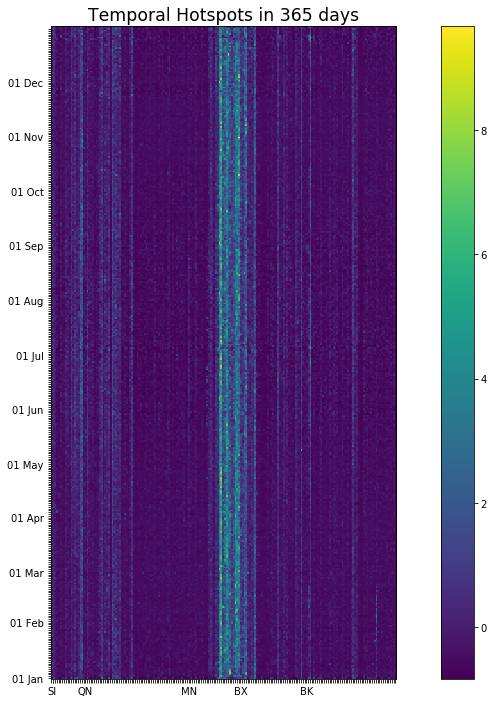

In [12]:
plt.clf()
fig = plt.figure(figsize=(16, 12))
ax_grph = plt.gca()
ax_grph.imshow(_grpby_365, cmap='viridis')
ax_grph.set_title('Temporal Hotspots in 365 days', fontdict={'fontsize':'xx-large'})
#colorbar
im = plt.imshow(_grpby_365, interpolation='nearest', origin='lower', cmap='viridis')
fig.colorbar(im, ax=ax_grph)

plt.yticks(range(len(str_dt_rng_monthly)), str_dt_rng_monthly)
plt.xticks(range(len(_xticks_trunc)), _xticks_trunc)
plt.show()

#### Zoom in on the hotspot

In [13]:
nb_shp = gpd.read_file('../data/Neighborhood Tabulation Areas/geo_export_734cc588-a881-4394-bdd7-9f757b306aa4.shp')
nta_dict = dict(zip(nb_shp['ntacode'].tolist(), nb_shp['ntaname'].tolist()))
nb_shp.shape

<Figure size 432x288 with 0 Axes>

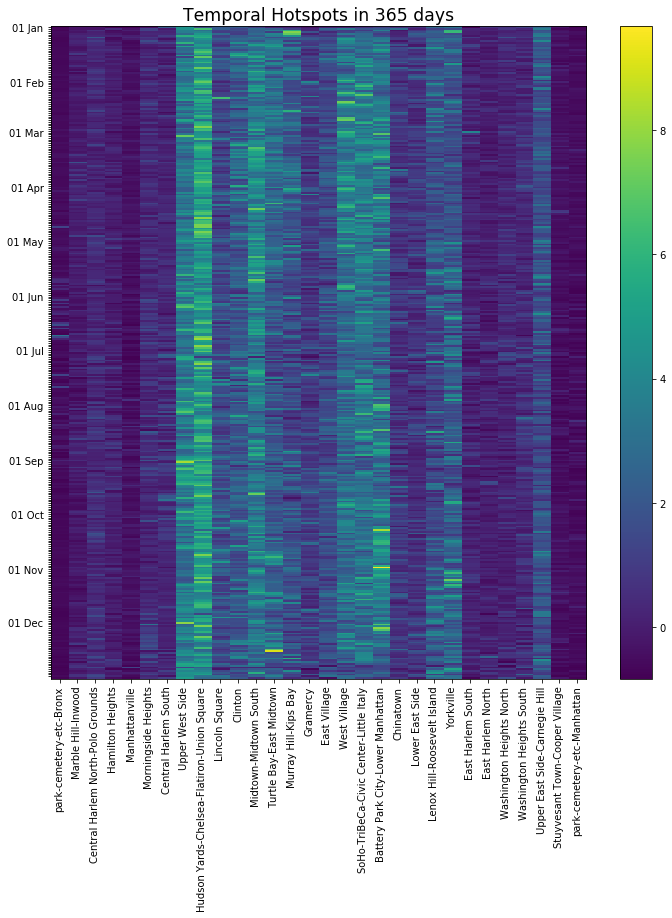

In [14]:
_xtick_nms = [nta_dict.get(e) for e in _xticks]

plt.clf()
fig = plt.figure(figsize=(12, 12))
ax_grph = plt.gca()
plt_dta = _grpby_365.iloc[:, int(_grpby_365.shape[1]/2)-10:int(_grpby_365.shape[1]/2)+20]
plt_dta_xtick_nms = _xtick_nms[int(_grpby_365.shape[1]/2)-10:int(_grpby_365.shape[1]/2)+20]

ax_grph.imshow(plt_dta, cmap='viridis',  aspect='auto')
ax_grph.set_title('Temporal Hotspots in 365 days', fontdict={'fontsize':'xx-large'})
fig.colorbar(im, ax=ax_grph)

plt.yticks(range(len(str_dt_rng_monthly)), str_dt_rng_monthly)
plt.xticks(range(len(plt_dta_xtick_nms)), plt_dta_xtick_nms, rotation=90)
plt.show()

#### Looking at Correlations of the hotspot neighborhoods

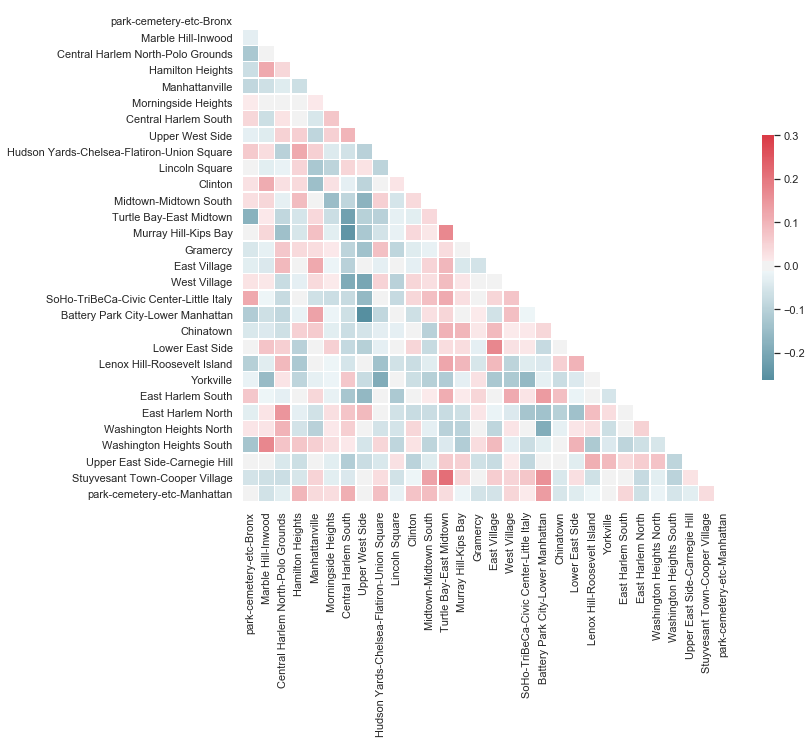

In [15]:
sns.set(style="white")

# Generate a large random dataset
rs = np.random.RandomState(33)

# Compute the correlation matrix
corr = pd.DataFrame(scale(plt_dta)).corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))


# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
ax = sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}
                , xticklabels=plt_dta_xtick_nms, yticklabels=plt_dta_xtick_nms)

### meanwhile standardization by feature does not yield visually discernable pattern

<Figure size 432x288 with 0 Axes>

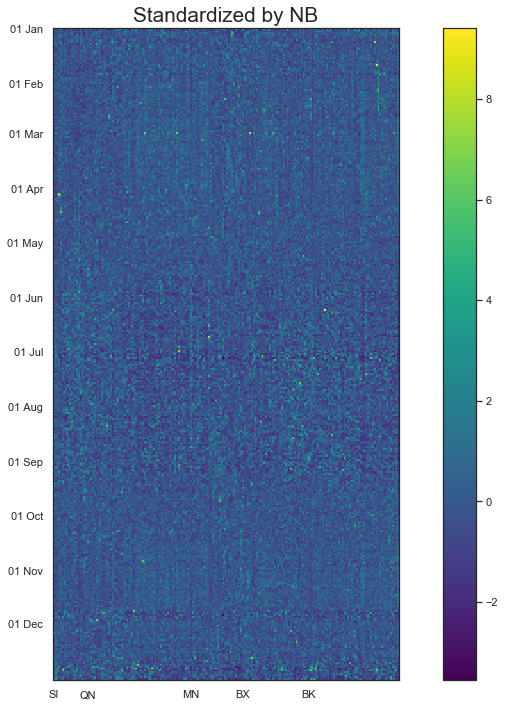

In [17]:
plt.clf()
fig = plt.figure(figsize=(16, 12))
ax_grph = plt.gca()
ax_grph.imshow(scale(_grpby_365), cmap='viridis')
ax_grph.set_title('Standardized by NB', fontdict={'fontsize':'xx-large'})
#colorbar
im = ax.imshow(scale(_grpby_365), interpolation='nearest', origin='lower', cmap='viridis')
fig.colorbar(im, ax=ax_grph)

plt.yticks(range(len(str_dt_rng_monthly)), str_dt_rng_monthly)
plt.xticks(range(len(_xticks_trunc)), _xticks_trunc)
plt.show()

### Singular Value Decomposition

Visualize each neighborhood's magnitude in row space of the matrix that is standardized counts of 194 neighborhoods along 365 date bins over 9 years. From the orthogonal row space, first 2 principal components are visualized against a shapefile. More information on [Singular Value Decomposition](https://cims.nyu.edu/~cfgranda/pages/MTDS_spring19/notes/svd.pdf)

In [18]:
u, s, v_T = svd(scale(_grpby_365))
u.shape, s.shape, v_T.shape

Text(0.5, 1.0, 'Singular Values')

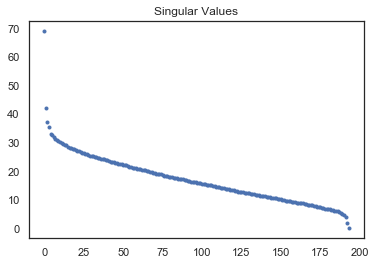

In [19]:
plt.plot(s, 'b.')
ax = plt.gca()
ax.set_title('Singular Values')

#### show the magnitude of each nb in first principal direction

In [20]:
v1_df = pd.DataFrame(
    data={
        'nb': [nta_dict[e] for e in _grpby_365.columns]
        , 'row_vector_magn': v_T.T[0]
    }
)
v1_df['abs_magn'] = v1_df['row_vector_magn'].apply(abs)
v1_df.sort_values('row_vector_magn', ascending=False).head(10)

,nb,row_vector_magn,abs_magn
137,Jackson Heights,0.193088,0.193088
64,Hunts Point,0.176133,0.176133
117,South Jamaica,0.143106,0.143106
81,Schuylerville-Throgs Neck-Edgewater Park,0.133612,0.133612
105,Battery Park City-Lower Manhattan,0.127986,0.127986
48,Erasmus,0.127898,0.127898
178,Grymes Hill-Clifton-Fox Hills,0.124960,0.124960
55,Bronxdale,0.123641,0.123641
27,Prospect Lefferts Gardens-Wingate,0.120424,0.120424
91,Manhattanville,0.120182,0.120182


In [21]:
v1_df.sort_values('row_vector_magn', ascending=False)['nb'].head(8).tolist()

['Jackson Heights',
 'Hunts Point',
 'South Jamaica',
 'Schuylerville-Throgs Neck-Edgewater Park',
 'Battery Park City-Lower Manhattan',
 'Erasmus',
 'Grymes Hill-Clifton-Fox Hills',
 'Bronxdale']

Text(0.5, 1.0, 'First principal direction ($v_1 \\in V$) of $M=USV^{T}$')

<Figure size 432x288 with 0 Axes>

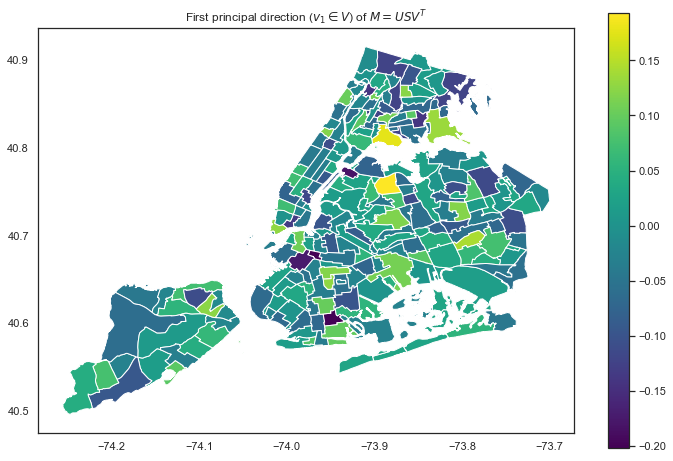

In [30]:
plt.clf()

df = v1_df
x = nb_shp.merge(df, left_on='ntaname', right_on='nb')
x.plot(column='row_vector_magn', cmap='viridis', legend=True, figsize=(12, 8))
ax = plt.gca()
ax.set_title('First principal direction ($v_1 \in V$) of $M=USV^{T}$')

#### show the magnitude of each nb in second principal direction

In [23]:
v2_df = pd.DataFrame(
    data={
        'nb': [nta_dict[e] for e in _grpby_365.columns]
        , 'row_vector_magn': v_T.T[1]
    }
)
v2_df['abs_magn'] = v2_df['row_vector_magn'].apply(abs)
v2_df.sort_values('row_vector_magn', ascending=False).head(10)

,nb,row_vector_magn,abs_magn
16,Park Slope-Gowanus,0.209742,0.209742
167,Laurelton,0.205529,0.205529
95,Hudson Yards-Chelsea-Flatiron-Union Square,0.172123,0.172123
50,park-cemetery-etc-Brooklyn,0.169715,0.169715
73,Van Nest-Morris Park-Westchester Square,0.165317,0.165317
146,Fresh Meadows-Utopia,0.163671,0.163671
118,Springfield Gardens North,0.141104,0.141104
165,Queensboro Hill,0.130297,0.130297
109,Yorkville,0.119094,0.119094
41,East New York,0.117783,0.117783


Text(0.5, 1.0, 'First principal direction ($v_2 \\in V$) of $M=USV^{T}$')

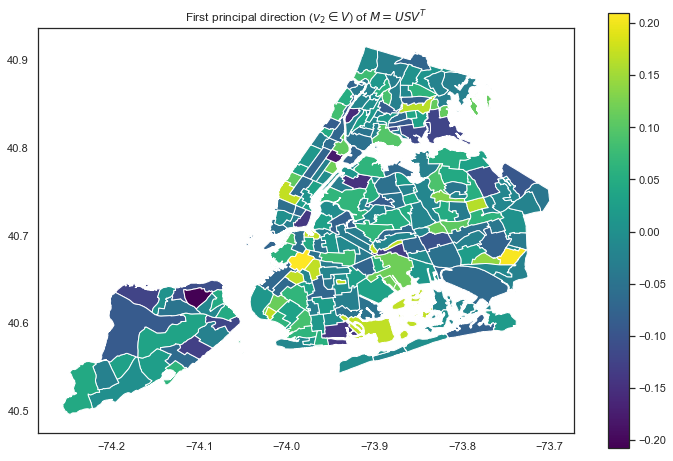

In [29]:
df = v2_df
x = nb_shp.merge(df, left_on='ntaname', right_on='nb')
x.plot(column='row_vector_magn', cmap='viridis', legend=True, figsize=(12, 8))
ax = plt.gca()
ax.set_title('First principal direction ($v_2 \in V$) of $M=USV^{T}$')